In [71]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [127]:
df= pd.read_csv("NVDA.csv",index_col='Date', parse_dates=True)
df.head()


,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
02/01/2015,0.483143,0.50325,0.50700,0.49525,0.50325,113680000
05/01/2015,0.474983,0.49475,0.50475,0.49250,0.50325,197952000
06/01/2015,0.460582,0.47975,0.49600,0.47925,0.49550,197764000
07/01/2015,0.459382,0.47850,0.48750,0.47700,0.48325,321808000
08/01/2015,0.476663,0.49650,0.49950,0.48375,0.48400,283780000


In [129]:
df.columns = df.columns.str.strip()
df = df[['Open', 'High', 'Close']]
df = df.apply(pd.to_numeric, errors='coerce')

In [131]:
#. Imputación de valores faltantes
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

In [133]:
# Escalado de los datos
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_imputed)

In [135]:

#Preparación de secuencias para LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 2])  # predice 'Close'
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(df_scaled, seq_length)


In [137]:
#División en entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [139]:

model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

C:\Users\shari\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [141]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 60, 100)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

In [143]:

#  Entrenamiento del modelo
history =model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - loss: 0.0400
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 8.5299e-05
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 5.7890e-05
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 5.9013e-05
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 4.8897e-05
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - loss: 3.9986e-05
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - loss: 4.7835e-05
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 3.8975e-05
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 3.8514e-05
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - loss: 5.9447e-05
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 3.6978e-05
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 5.4424e-05
Epoch 13/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.7839e-05
Epoch 14/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 3.2606e-05
Epoch 15/50
6

In [145]:
#  Predicción
y_pred = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step


In [146]:
#  Inversión del escalado
y_test_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 2)), y_test.reshape(-1, 1)), axis=1))[:, 2]
y_pred_inv = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 2)), y_pred), axis=1))[:, 2]


In [149]:
# Evaluacion del proyecto
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 8.09
MAE: 5.89


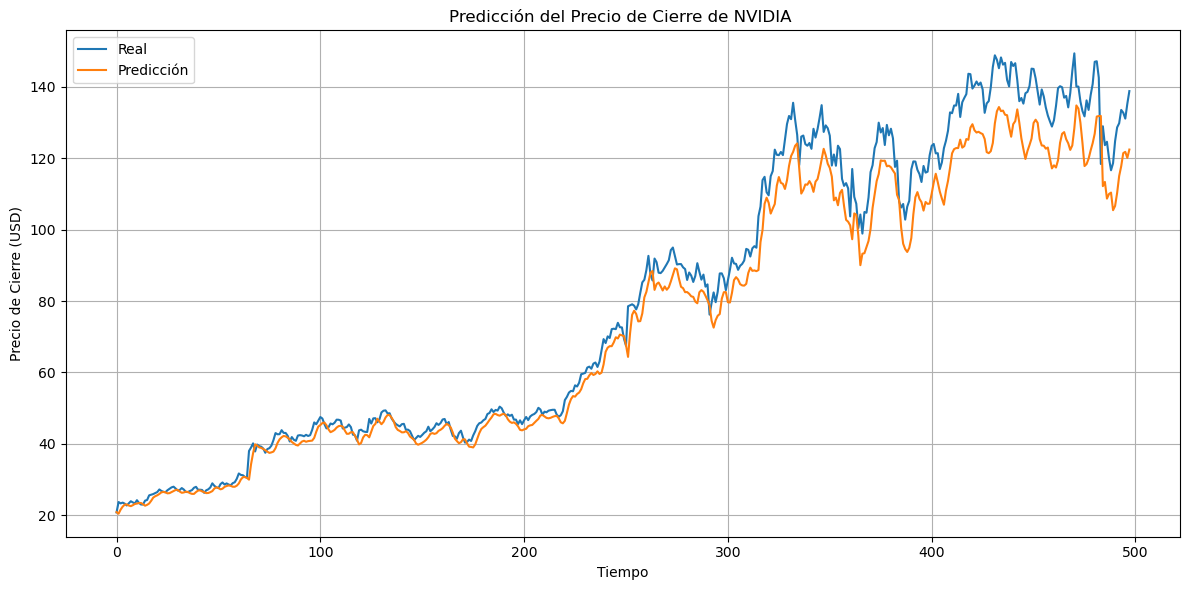

In [155]:

 # Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Real')
plt.plot(y_pred_inv, label='Predicción')
plt.title('Predicción del Precio de Cierre de NVIDIA ')
plt.xlabel('Tiempo')
plt.ylabel('Precio de Cierre (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [153]:
# 13. Crear DataFrame comparativo de resultados finales
fechas_test = df_imputed.index[-len(y_test_inv):]
resultados = pd.DataFrame({
    'Fecha': fechas_test,
    'Precio Real': y_test_inv,
    'Precio Predicho': y_pred_inv
})

resultados.set_index('Fecha', inplace=True)
print(resultados.tail(10000000))

            Precio Real  Precio Predicho
Fecha                                   
22/02/2023    20.754000        20.850553
23/02/2023    23.664000        20.394131
24/02/2023    23.285999        21.534796
27/02/2023    23.500999        22.374354
28/02/2023    23.216000        22.929210
...                 ...              ...
10/02/2025   133.570007       117.793163
11/02/2025   132.800003       121.470186
12/02/2025   131.139999       121.822686
13/02/2025   135.289993       120.126372
14/02/2025   138.850006       122.462316

[498 rows x 2 columns]
